In [1]:
# Importing required libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import string

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TUKL summer internship/week1/amazon_alexa.tsv',sep='\t')
# Creating a new column sentiment based on overall ratings
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [5]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [6]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [7]:
data_v1.head()

,verified_reviews,sentiment
0,Love my Echo!,Positive
1,Loved it!,Positive
2,"Sometimes while playing a game, you can answer...",Positive
3,I have had a lot of fun with this thing. My 4 ...,Positive
4,Music,Positive


In [8]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [9]:
def cleaning(df, stop_words):

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split())) 

                               

    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')

            

    # Removing stop words

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    #lower casing
    df['verified_reviews'] = df['verified_reviews'].str.lower()

    #punctuation removal         
    df["verified_reviews"] = df["verified_reviews"].apply(lambda text: remove_punctuation(text))
    # Lemmatization

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))

            

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [10]:
data_v1.head()

,verified_reviews,sentiment
0,love echo,Positive
1,love it,Positive
2,sometimes playing game answer question correct...,Positive
3,ha lot fun thing 4 yr ol learns inosaurs contr...,Positive
4,music,Positive


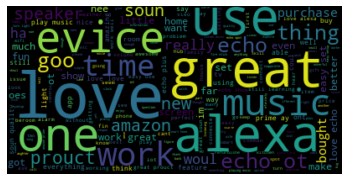

In [11]:
#visualization the most common words
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
#tokenizer
#Num_words – This hyperparameter refers to the number of words to keep based on the frequency of words.
#Split – This hyperparameter refers to the separator used for splitting the word.
#pad_sequence() function is used to convert a list of sequences into a 2D NumPy array.
#Tokenization and conversion into numerical vectors
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)

In [16]:
X.shape[1]

235

In [17]:
#neural nets can learn word embeddings by themselves
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))#500 because tokenizer num_words=500 and 120 instead of this it can be anything
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))# LSTM units can be anything drop out value can be anything
model.add(Dense(2,activation='softmax'))# 2 because binary sentiments
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 235, 120)          60000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 235, 120)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 176)               209088    
_________________________________________________________________
dense (Dense)                (None, 2)                 354       
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [20]:
X_train.shape,y_train.shape

((2205, 235), (2205, 2))

In [21]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
69/69 [==============================] - 92s 981ms/step - loss: 0.4421 - accuracy: 0.8576
Epoch 2/5
69/69 [==============================] - 68s 979ms/step - loss: 0.3278 - accuracy: 0.8676
Epoch 3/5
69/69 [==============================] - 68s 979ms/step - loss: 0.2528 - accuracy: 0.9001
Epoch 4/5
69/69 [==============================] - 67s 978ms/step - loss: 0.1928 - accuracy: 0.9280
Epoch 5/5
69/69 [==============================] - 68s 979ms/step - loss: 0.1902 - accuracy: 0.9225


In [22]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 5s 120ms/step - loss: 0.2613 - accuracy: 0.8857


[0.2613275647163391, 0.8857142925262451]